# Reimplementing a Choice-Based Revenue Management Simulation

We reimplement Simulation 2 from "Revenue Management Under a General Discrete Choice Model of Consumer Behavior" by Talluri and van Ryzin 2004. 

In [1]:
import time

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from data import REVENUES
from choice import choice_dp_tabulate, mnl, efficient_sets, exponomial
from simulation import simulate, calculate_statistics, confidence_interval, precompute_emsr_assortments
from estimation import expectation_maximization

np.random.seed(0)  # For reproducibility

In [2]:
# Problem Constants
C = 185
C_max = 250
T = 410
mean_demand = 205
n = len(REVENUES)
arrival_rate = 0.5
# high is -0.005, low is -0.0015, we will calculate a range of betas
beta = -0.005
estimated_beta = -0.0048
U = np.array(REVENUES, dtype=float) * beta
estimated_U = np.array(REVENUES, dtype=float) * estimated_beta
w = np.exp(U)

In [3]:
# Implement Choice by solving DP
value_fcn, action_fcn = choice_dp_tabulate(arrival_rate, C_max, T, list(REVENUES), list(estimated_U), mnl)
# Implement EMSR by precomputing for each x, t remaining
emsr_assort = precompute_emsr_assortments(C_max, T, mean_demand, n)

In [4]:
utility_fcn = lambda b: b * REVENUES

# check if historical_purchases.npy and historical_offers.npy exist
try:
    purchases_flat = np.load("historical_purchases.npy", allow_pickle=True)
    offers_flat = np.load("historical_offers.npy", allow_pickle=True)
except FileNotFoundError:
    # Generate 50 days of data for ESMR in order to do EM estimation
    days = 50
    offers = np.zeros((days, T), dtype=object)
    purchases = np.zeros((days, T), dtype=int)

    for day in range(days):
        # Simulate the day
        purchases[day, :], _, offers[day, :], _ = simulate(
            T, C, arrival_rate, w, emsr_assort, action_fcn
        )

    # turn all -2 to -1 in purchases
    purchases[purchases == -2] = -1

    # flatten both arrays
    purchases_flat = purchases.flatten()
    offers_flat = offers.flatten()

    # save to historical data
    np.save("historical_purchases.npy", purchases_flat)
    np.save("historical_offers.npy", offers_flat)


In [5]:
# estimate beta using EM
# expectation_maximization(0, 1, utility_fcn, offers_flat, purchases_flat)

In [6]:
# expectation_maximization(-0.0015, 0.5, utility_fcn, offers_flat, purchases_flat)

In [7]:
###
### Experiment 1: Revenue and Load Factor Changing with C
###
replications = 50
C_list = np.array([80, 100, 120, 140, 160, 180, 200, 220, 240])

try:
    load_factors = np.load("load_factors_1.npy")
    revenues = np.load("revenues_1.npy")
except FileNotFoundError:
    load_factors = np.zeros((len(C_list), replications, 2))  # 2 for EMSR and MNL
    revenues = np.zeros((len(C_list), replications, 2))  # 2 for EMSR and MNL

    for i, C_val in enumerate(C_list):
        for j in range(replications):
            esmr_purchases, mnl_purchases, esmr_offers, mnl_offers = simulate(T, C_val, arrival_rate, w, emsr_assort, action_fcn)
            esmr_load_factor, esmr_revenue = calculate_statistics(esmr_purchases, C_val)
            mnl_load_factor, mnl_revenue = calculate_statistics(mnl_purchases, C_val)
            load_factors[i, j, 0] = esmr_load_factor
            load_factors[i, j, 1] = mnl_load_factor
            revenues[i, j, 0] = esmr_revenue
            revenues[i, j, 1] = mnl_revenue

    # save results
    np.save("load_factors_1.npy", load_factors)
    np.save("revenues_1.npy", revenues)

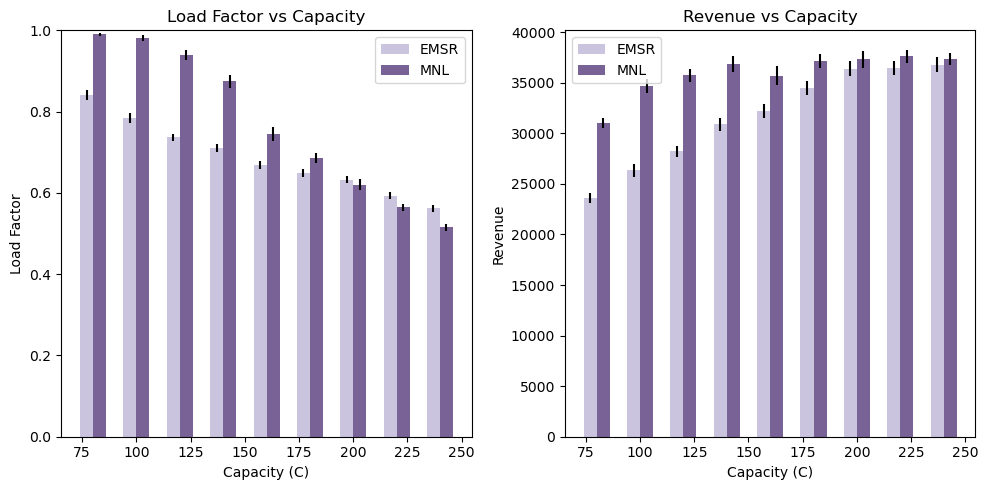

In [8]:
load_factors = np.load("load_factors_1.npy")
revenues = np.load("revenues_1.npy")

# plot load factors, use barplot with error bars
load_factors_mean = np.mean(load_factors, axis=1)
load_factors_std = np.std(load_factors, axis=1) * 1.96 / np.sqrt(replications)  # 95% CI
revenues_mean = np.mean(revenues, axis=1)
revenues_std = np.std(revenues, axis=1) * 1.96 / np.sqrt(replications)  # 95% CI

width = 6
emsr_color = '#B6ACD1'
mnl_color = '#401F68'

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(C_list - width / 2, load_factors_mean[:, 0], width=width, yerr=load_factors_std[:, 0], label='EMSR', alpha=0.7, color=emsr_color)
plt.bar(C_list + width / 2, load_factors_mean[:, 1], width=width, yerr=load_factors_std[:, 1], label='MNL', alpha=0.7, color=mnl_color)
plt.xlabel('Capacity (C)')
plt.ylabel('Load Factor')
plt.title('Load Factor vs Capacity')
plt.ylim(0, 1)
plt.legend()
plt.subplot(1, 2, 2)
plt.bar(C_list - width / 2, revenues_mean[:, 0], width=width, yerr=revenues_std[:, 0], label='EMSR', alpha=0.7, color=emsr_color)
plt.bar(C_list + width / 2, revenues_mean[:, 1], width=width, yerr=revenues_std[:, 1], label='MNL', alpha=0.7, color=mnl_color)
plt.xlabel('Capacity (C)')
plt.ylabel('Revenue')
plt.title('Revenue vs Capacity')
plt.legend()
plt.tight_layout()
plt.savefig("experiment_1_results.png")
plt.show()

In [9]:
###
### Experiment 2: Revenue and Load Factor Changing with beta
###
beta_list = np.array([-0.005, -0.004, -0.003, -0.002, -0.001])

try:
    load_factors = np.load("load_factors_2.npy")
    revenues = np.load("revenues_2.npy")
except FileNotFoundError:    
    C_val = 185  # Fixed capacity for this experiment
    load_factors = np.zeros((len(beta_list), replications, 2))  # 2 for EMSR and MNL
    revenues = np.zeros((len(beta_list), replications, 2))  # 2 for EMSR and MNL

    for i, beta in enumerate(beta_list):
        w = np.exp(utility_fcn(beta))
        # Implement Choice by solving DP
        U = np.array(REVENUES, dtype=float) * beta
        value_fcn, action_fcn = choice_dp_tabulate(arrival_rate, C_max, T, list(REVENUES), list(U), mnl)
        for j in range(replications):
            esmr_purchases, mnl_purchases, esmr_offers, mnl_offers = simulate(T, C_val, arrival_rate, w, emsr_assort, action_fcn)
            esmr_load_factor, esmr_revenue = calculate_statistics(esmr_purchases, C_val)
            mnl_load_factor, mnl_revenue = calculate_statistics(mnl_purchases, C_val)
            load_factors[i, j, 0] = esmr_load_factor
            load_factors[i, j, 1] = mnl_load_factor
            revenues[i, j, 0] = esmr_revenue
            revenues[i, j, 1] = mnl_revenue

    # save results
    np.save("load_factors_2.npy", load_factors)
    np.save("revenues_2.npy", revenues)

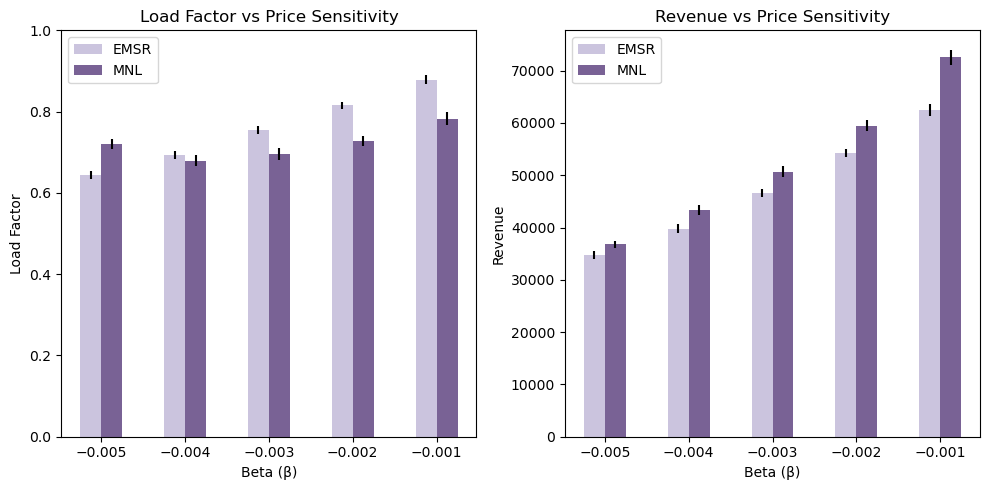

In [10]:
load_factors = np.load("load_factors_2.npy")
revenues = np.load("revenues_2.npy")

# plot load factors, use barplot with error bars
load_factors_mean = np.mean(load_factors, axis=1)
load_factors_std = np.std(load_factors, axis=1) * 1.96 / np.sqrt(replications)  # 95% CI
revenues_mean = np.mean(revenues, axis=1)
revenues_std = np.std(revenues, axis=1) * 1.96 / np.sqrt(replications)  # 95% CI

width = 0.00025
# hex 'B6ACD1' color for EMSR, '4E2A84' for MNL
emsr_color = '#B6ACD1'
mnl_color = '#401F68'

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(beta_list - width / 2, load_factors_mean[:, 0], width=width, yerr=load_factors_std[:, 0], label='EMSR', alpha=0.7, color=emsr_color)
plt.bar(beta_list + width / 2, load_factors_mean[:, 1], width=width, yerr=load_factors_std[:, 1], label='MNL', alpha=0.7, color=mnl_color)
plt.xlabel('Beta (β)')
plt.ylabel('Load Factor')
plt.ylim(0, 1)
plt.title('Load Factor vs Price Sensitivity')
plt.legend()
plt.subplot(1, 2, 2)
plt.bar(beta_list - width / 2, revenues_mean[:, 0], width=width, yerr=revenues_std[:, 0], label='EMSR', alpha=0.7, color=emsr_color)
plt.bar(beta_list + width / 2, revenues_mean[:, 1], width=width, yerr=revenues_std[:, 1], label='MNL', alpha=0.7, color=mnl_color)
plt.xlabel('Beta (β)')
plt.ylabel('Revenue')
plt.title('Revenue vs Price Sensitivity')
plt.legend()
plt.tight_layout()
plt.savefig("experiment_2_results.png")
plt.show()

Computing efficient sets for r = [6, 5, 4, 3]...
Time taken for r = [6, 5, 4, 3]: 0.0026 seconds
Computing efficient sets for r = [7, 6, 5, 4, 3]...
Time taken for r = [7, 6, 5, 4, 3]: 0.0058 seconds
Computing efficient sets for r = [8, 7, 6, 5, 4, 3]...
Time taken for r = [8, 7, 6, 5, 4, 3]: 0.0763 seconds
Computing efficient sets for r = [9, 8, 7, 6, 5, 4, 3]...
Time taken for r = [9, 8, 7, 6, 5, 4, 3]: 0.0443 seconds
Computing efficient sets for r = [10, 9, 8, 7, 6, 5, 4, 3]...
Time taken for r = [10, 9, 8, 7, 6, 5, 4, 3]: 0.0668 seconds
Computing efficient sets for r = [11, 10, 9, 8, 7, 6, 5, 4, 3]...
Time taken for r = [11, 10, 9, 8, 7, 6, 5, 4, 3]: 0.1342 seconds
Computing efficient sets for r = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3]...
Time taken for r = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3]: 0.3687 seconds
Computing efficient sets for r = [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]...
Time taken for r = [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]: 0.8392 seconds
Computing efficient sets for r = [14

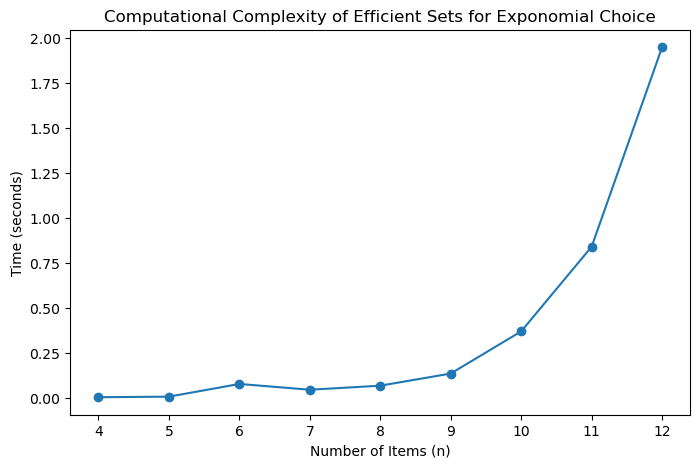

In [15]:
###
### Experiment 3: Computational Complexity of Computing Efficient Sets
###

r_sets = [
    list(range(n + 2, 2, -1)) for n in [4, 5, 6, 7, 8, 9, 10, 11, 12]
]
times = []

for r in r_sets:
    start_time = time.perf_counter()
    print(f"Computing efficient sets for r = {r}...")
    efficient_sets([float(ri) for ri in r], list(np.array(r) * -0.005), exponomial)
    end_time = time.perf_counter()
    print(f"Time taken for r = {r}: {end_time - start_time:.4f} seconds")
    times.append(end_time - start_time)

# Plotting the computational complexity
plt.figure(figsize=(8, 5))
plt.plot([len(r) for r in r_sets], times, marker='o')
plt.xlabel('Number of Items (n)')
plt.ylabel('Time (seconds)')
plt.title('Computational Complexity of Efficient Sets for Exponomial Choice')
plt.xticks([len(r) for r in r_sets], [str(len(r)) for r in r_sets])
plt.savefig("experiment_3_results.png")